In [1]:
from keras.models import Sequential
from keras.layers import LSTM, Input, Dense
from keras import activations


import numpy as np
import pandas as pd
import operator
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import math

from keras.models import load_model



sns.set_style("whitegrid")
current_palette = sns.color_palette('colorblind')

Using TensorFlow backend.


#### Lade trainierte Netze/models

In [2]:
model_name_Fz = 'NN3_2_2_2_Fz'
model_name_My = 'NN2_3_1_2_My'
model_name_Mz = 'NN2_3_1_2_Mz'

model_Fz = load_model('model/'+model_name_Fz)
Model_My = load_model('model/'+model_name_My)
Model_Mz = load_model('model/'+model_name_Mz)

In [3]:
#x_train = np.load('Regression_Daten/x_train.npy').astype('float32')
#x_val = np.load('Regression_Daten/x_val.npy').astype('float32')
#x_test = np.load('Regression_Daten/x_test.npy').astype('float32')

#y_train = np.load('Regression_Daten/y_Fz_train2.npy').astype('float32')
#y_val = np.load('Regression_Daten/y_Fz_val2.npy').astype('float32')
#y_test = np.load('Regression_Daten/y_Fz_test2.npy').astype('float32')

#### Lade Prototypdaten und wandle Daten in geeignetes Format um

In [4]:
features = 20 #entspricht der Anzahl der Sensoren
timesteps = 22 # *0.05s --> definiert die Zeitspanne in der zeitliche Abhängigkeiten vom Netzwerk erlernt werden können
batchsize = 128
LSTM_size = 32 #ANzahl der LSTM-Zellen
Dense_size = 32
epochen = 100


#Zur Normierung benötigt -> entspricht der Normierung aus dem Trainingsprozess
norm_mean = np.load('NormData_mean.npy')
norm_std = np.load('NormData_std.npy')

In [5]:
sock_data = pd.read_csv('Regression_Daten/socketest3.txt',delimiter='\t', header=0)

#### Berücksichtige nur Daten zwischen erstem und letztem Trigger:

    falls nicht benötigt auskommentieren!

In [6]:
#Finde Triggerpunkte
x = sock_data.Trigger
trig=[]
get_indexes = lambda x, xs: [i for (y, i) in zip(xs, range(len(xs))) if x == y]
trig=get_indexes(1,x)
#Lösche Zeilen vor erstem und nach letztem Triggerpunkt
sock_data=sock_data.drop(sock_data.index[range(max(trig)+1,len(sock_data.index))])
sock_data=sock_data.drop(sock_data.index[range(0,min(trig))])

In [8]:
#Upsampling

sock_data=sock_data.rename(columns={"Milisec": "ms"})
sock_data.ms = np.linspace(start=0,stop=(len(sock_data)*100-100),num=len(sock_data))#(sock_data.ms-sock_data.ms[min(trig)])

#Mache Indizes zu "TimedeltaIndizes" --> Vorraussetzung zum einfachen Resampeling
sock_data.index = pd.TimedeltaIndex(sock_data.ms,  unit='ms')

sock_data = sock_data.drop(columns="Time") #Time ein tf-object das nicht mehr benötigt wird

sock_data = sock_data.resample('50L').asfreq() #upsampling: '50L' entspricht 50ms

sock_data = sock_data.interpolate(method='linear')

#### Setze den Millisekunden(ms)-Startwert des Dataframes (df) auf Null

In [9]:
sock_data=sock_data.rename(columns={"Milisec": "ms"})
sock_data.ms = np.linspace(start=0,stop=(len(sock_data)*50-50),num=len(sock_data))#(sock_data.ms-sock_data.ms[min(trig)])

#Mache Indizes zu "TimedeltaIndizes" --> Vorraussetzung zum einfachen Resampeling
sock_data.index = pd.TimedeltaIndex(sock_data.ms,  unit='ms')

In [10]:
sock_data = sock_data.drop(['ms', 'M1A6', 'M2A6', 'Trigger'], axis=1) #Unnötige Spalten fallen lassen

In [12]:
#Normierung
sock_data -= norm_mean
sock_data /= norm_std

#### Reshaping...
... zu Format (samples, timesteps, features)

In [13]:
samples = None
timesteps = 22 #Auf 22 sek festgelegt (22*0.05s = 1.1s) ; ungleich 20 um von features.shape unterscheiden zu können 
features = len(sock_data.columns) #Anzahl der Sensoren
step = 1 #Versatz zum nächsten Sample; ungerade damit Interpolierte und urspüngliche Werte abwechselnd in die jeweilige LSTM-Zelle eingehen.
batchsize = 128

In [15]:
temp = np.ndarray((1,timesteps,features))
temp.fill(0)
sock_np = np.ndarray((1,timesteps,features))
sock_np.fill(0)

a = int(((len(sock_data))-timesteps)/step)

for i in range(a):
    for j in range(timesteps):
        for k in range(features):
            temp[0,j,k] = sock_data.iloc[(j+i*step),k]
    sock_np = np.concatenate((sock_np,temp), axis=0)
sock_np = sock_np[1:]

In [16]:
sock_np = sock_np[:int(sock_np.shape[0]/batchsize)*batchsize]

In [17]:
sock_np.shape

(16768, 22, 20)

#### Anwendung des trainierten Models auf 'unbekannte' Trainingsdaten

In [18]:
predictions_Fz = model_Fz.predict(sock_np,batch_size=batchsize)
#y_real = y_test

In [19]:
predictions_Fz.shape

(16768, 1)

In [1]:
plt.figure(num=None, figsize=(11,5), dpi=200, facecolor='w', edgecolor='k')
plt.plot(np.linspace(0,len(predictions_FZ)*0.05-0.05,len(predictions_FZ)), y_real, label='Bindungswerte', linewidth=0.7)
plt.plot(np.linspace(0,len(predictions_Fz)*0.05-0.05,len(predictions_Fz)), predictions_Fz,'r', label='NN-Ausgabe', linewidth=0.9)

plt.title('Vergleich der NN-Ausgabe der Testdaten des ' +model_name_Fz +' mit den Bindungswerten')
plt.xlabel('Zeit [s]')
plt.ylabel('Fz [N]')
plt.legend(bbox_to_anchor=(0.61, 0.15, 0.55, 0.38), borderaxespad=0)
#plt.xlim(left=140, right=220)
#plt.xlim(left=150, right=200)
#plt.ylim(bottom=-10, top=10)
plt.show()

NameError: name 'plt' is not defined

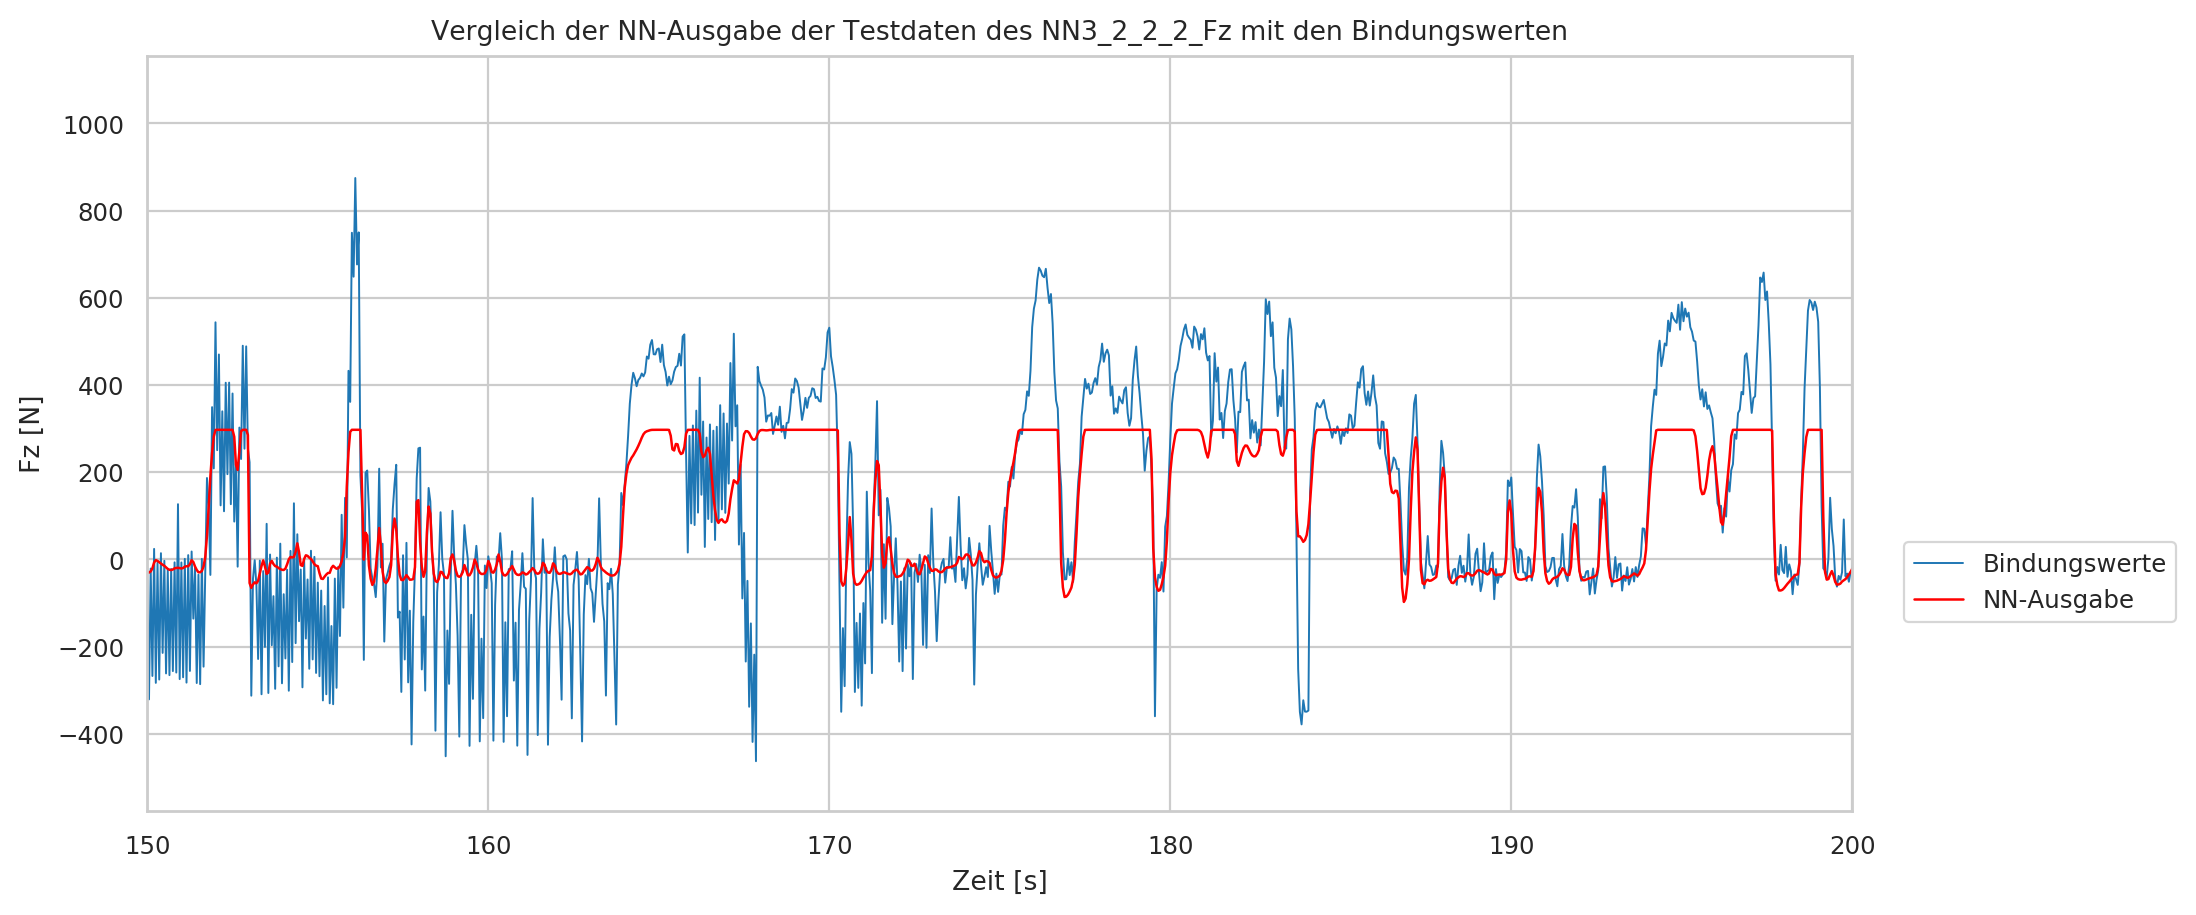

In [27]:
plt.figure(num=None, figsize=(11,5), dpi=200, facecolor='w', edgecolor='k')
plt.plot(np.linspace(0,len(predictions)*0.05-0.05,len(predictions)), y_real, label='Bindungswerte', linewidth=0.7)
plt.plot(np.linspace(0,len(predictions)*0.05-0.05,len(predictions)), predictions,'r', label='NN-Ausgabe', linewidth=0.9)

plt.title('Vergleich der NN-Ausgabe der Testdaten des ' +name +' mit den Bindungswerten')
plt.xlabel('Zeit [s]')
plt.ylabel('Fz [N]')
plt.legend(bbox_to_anchor=(0.61, 0.25, 0.58, 0.45), borderaxespad=0)
#plt.xlim(left=0, right=50)
plt.xlim(left=150, right=200)
#plt.ylim(bottom=-10, top=10)
plt.show()

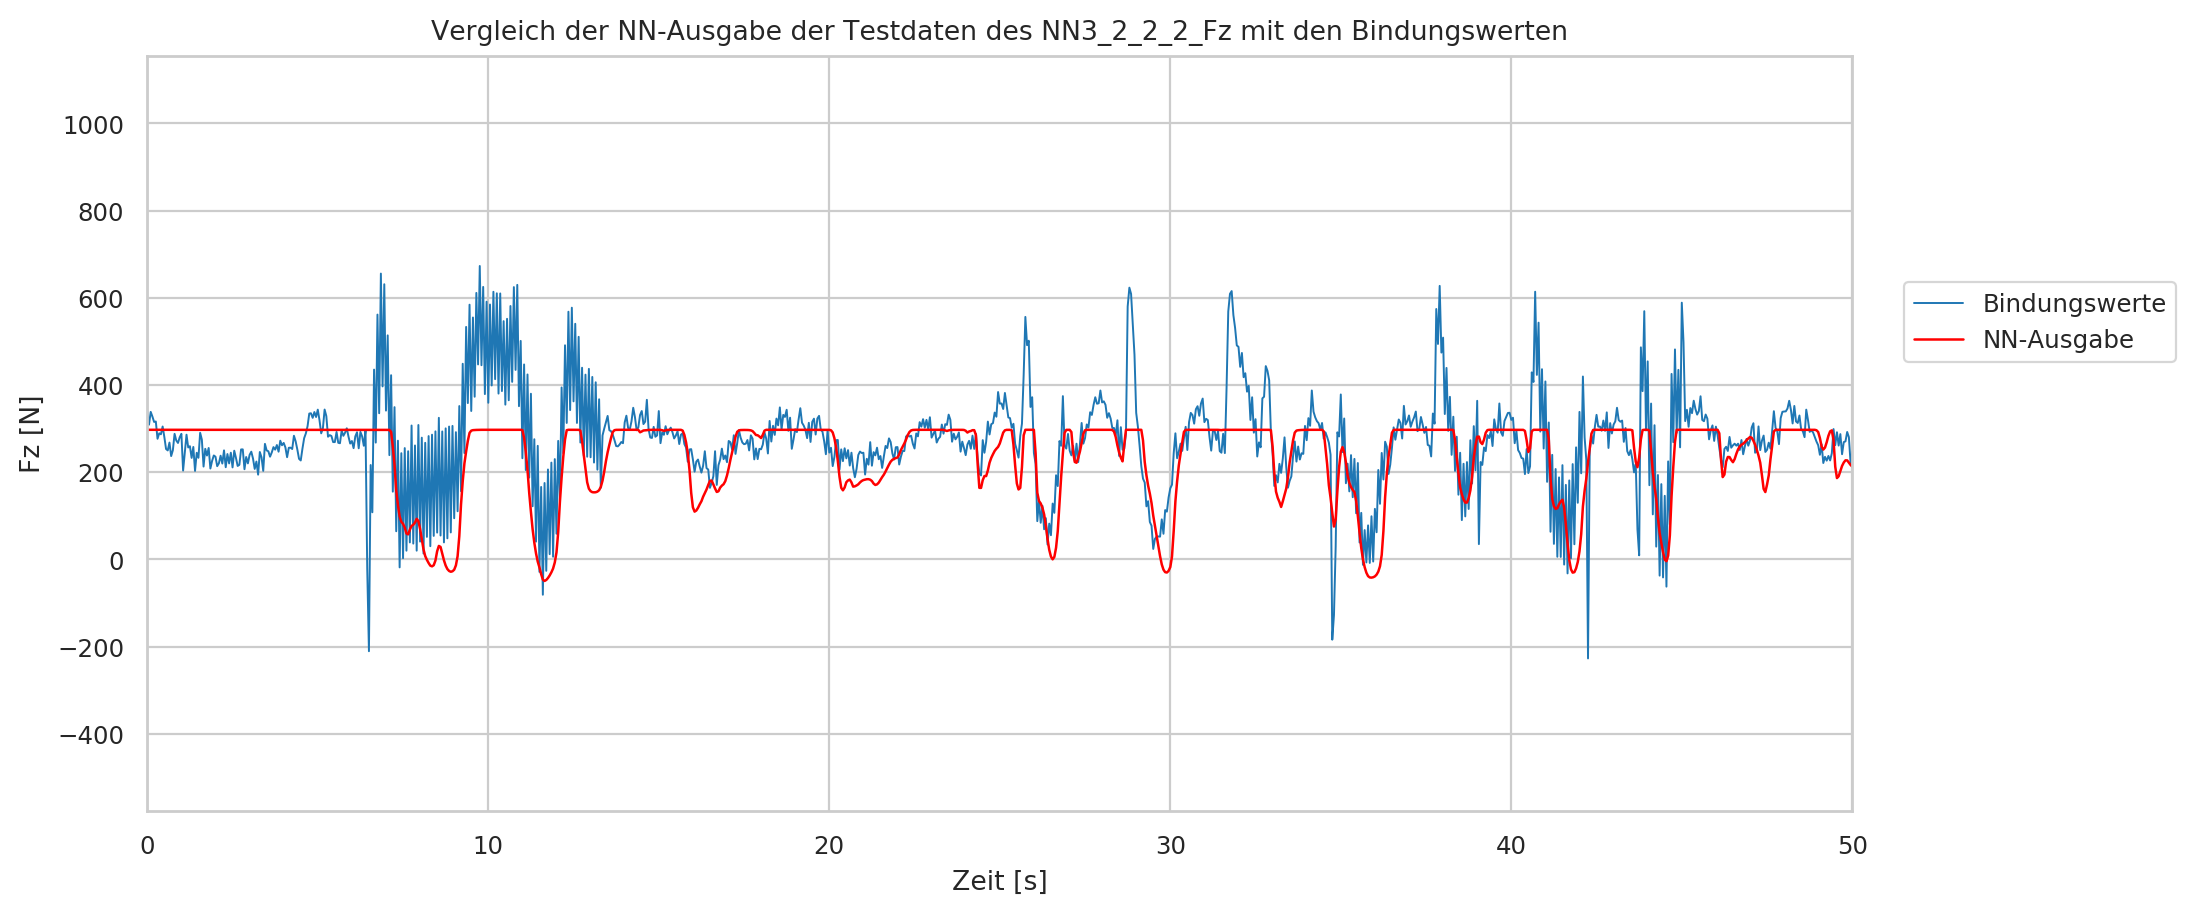

In [28]:
plt.figure(num=None, figsize=(11,5), dpi=200, facecolor='w', edgecolor='k')
plt.plot(np.linspace(0,len(predictions)*0.05-0.05,len(predictions)), y_real, label='Bindungswerte', linewidth=0.7)
plt.plot(np.linspace(0,len(predictions)*0.05-0.05,len(predictions)), predictions,'r', label='NN-Ausgabe', linewidth=0.9)

plt.title('Vergleich der NN-Ausgabe der Testdaten des ' +name +' mit den Bindungswerten')
plt.xlabel('Zeit [s]')
plt.ylabel('Fz [N]')
plt.legend(bbox_to_anchor=(0.61, 0.25, 0.58, 0.45), borderaxespad=0)
plt.xlim(left=0, right=50)
#plt.xlim(left=150, right=200)
#plt.ylim(bottom=-10, top=10)
plt.show()

## Zusammenfassung

In [29]:
# Nach welcher Epoche sollte das Training optimalerweise abgeschlossen werden?
# Vorgehen: einmal Netzwerk berechnen in 25 Epochen -> optimale Epochenanzahl anhand 'min_index_val_loss+1' ablesen und als Parameter oben angeben,
#           danach Netzwerk neu berechnen lassen.
min_index_val_loss, min_value_val_loss = min(enumerate(history_dict['val_loss']), key=operator.itemgetter(1))
#max_index_val_acc, max_value_val_acc = max(enumerate(history_dict['val_acc']), key=operator.itemgetter(1))
print('Ergebnisse der Validierungsdaten:')
print('  opimale Epochenanzahl:                 '+str(min_index_val_loss+1))
print('  minimaler Verlust:                     '+str(min_value_val_loss)+'\n')

print('Ergebnisse der Trainingdaten zur optimalen Epochenzahl:')
print('  Verlust:                               '+str(history_dict['loss'][min_index_val_loss]) + '\n')


# Beurteilung der Testdaten: Vergleich von 'predictions' mit y_real
#                  - Kreuzkorrelation
#                  - Euklidsche Distanz
#   Kreuzkorrelation
print('Vergleich der Vorhersagewerte mit den Bindungswerten:')
print('  Korrelationskoeffizient:               '+ str(np.corrcoef(np.transpose(predictions),np.transpose(y_real))[0,1]))

#   Euklidsche Distanz
summe=0
for i in range(len(predictions)):
    summe+=math.pow(predictions[i]-y_real[i],2)
print('  Euklidsche Distanz:                    '+ str(math.sqrt(summe))+'\n\n')

print(model.summary())

Ergebnisse der Validierungsdaten:
  opimale Epochenanzahl:                 99
  minimaler Verlust:                     23815.19203783118

Ergebnisse der Trainingdaten zur optimalen Epochenzahl:
  Verlust:                               10046.819988807936

Vergleich der Vorhersagewerte mit den Bindungswerten:
  Korrelationskoeffizient:               0.7636905462652928
  Euklidsche Distanz:                    9169.021157695326


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 22, 32)            6784      
_________________________________________________________________
lstm_5 (LSTM)                (None, 22, 32)            8320      
_________________________________________________________________
lstm_6 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_4 (Dense)              (None, 32)   

In [30]:
print(name)

NN3_2_2_2_Fz


In [31]:
#model.save('model/'+name) 

In [32]:
import os; os.system('say "Berechnung beendet   '+name+'"'); print('\a\a\a') #gibt unter MacOS Soundsignal, wenn berechnung beendet ist


